In [68]:
import requests
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import importlib
import osmnx as ox
import networkx as nx
# import networkx.algorithms.traversal.breadth_first_search as bfs
from math import ceil

import LTA_API_key
import helper_functions.routing.publicTransit
import helper_functions.utils

importlib.reload(LTA_API_key)
importlib.reload(helper_functions.routing.publicTransit)
importlib.reload(helper_functions.utils)

import LTA_API_key as apiKeys
import helper_functions.routing.publicTransit as publicTransit
import helper_functions.utils as utils
from scipy.spatial.distance import cdist
from datetime import datetime

# OneMapAPI

### Get token

In [212]:
headers = publicTransit.generate_OneMap_token()

### Search

In [213]:
location = '59159 (BUS STOP)'

url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={location}&returnGeom=Y&getAddrDetails=Y"
    
response = publicTransit.get_OneMap_response(url,headers=headers)
response_first_result = response['results'] # get first item in the list
response_first_result

[{'SEARCHVAL': '59159 (BUS STOP)',
  'BLK_NO': '',
  'ROAD_NAME': 'YISHUN AVE 5',
  'BUILDING': '59159 (BUS STOP)',
  'ADDRESS': '59159 (BUS STOP)',
  'POSTAL': 'NIL',
  'X': '28150.4695976423',
  'Y': '45808.9831599183',
  'LATITUDE': '1.4305546622766',
  'LONGITUDE': '103.83467068843'}]

In [ ]:
print(response['plan']['itineraries'][0]['legs'][1]['from']['arrival'])
print(response['plan']['itineraries'][0]['legs'][1]['from']['departure'])
print(response['plan']['itineraries'][0]['legs'][1]['startTime'])
print(response['plan']['itineraries'][0]['legs'][1]['endTime'])
print(response['plan']['itineraries'][0]['legs'][1]['duration'])
response['plan']['itineraries'][0]['legs'][1]

### Get data layers

In [214]:
url = "https://www.onemap.gov.sg/api/public/themesvc/getAllThemesInfo?moreInfo=Y"
response = publicTransit.get_OneMap_response(url,headers=headers)
response

{'Theme_Names': [{'THEMENAME': 'After Death Facilities',
   'QUERYNAME': 'afterdeathfacilities',
   'ICON': 'coffina20.jpg',
   'EXPIRY_DATE': '31/12/2028',
   'PUBLISHED_DATE': '01/01/2012',
   'CATEGORY': 'Environment',
   'THEME_OWNER': 'NATIONAL ENVIRONMENT AGENCY'},
  {'THEMENAME': 'Kindergartens',
   'QUERYNAME': 'kindergartens',
   'ICON': 'school.gif',
   'EXPIRY_DATE': '31/12/2026',
   'PUBLISHED_DATE': '01/01/2012',
   'CATEGORY': 'Education',
   'THEME_OWNER': 'EARLY CHILDHOOD DEVELOPMENT AGENCY'},
  {'THEMENAME': 'Community Clubs',
   'QUERYNAME': 'communityclubs',
   'ICON': 'PA.jpg',
   'EXPIRY_DATE': '30/12/2022',
   'PUBLISHED_DATE': '31/12/2011',
   'CATEGORY': 'Community',
   'THEME_OWNER': "PEOPLE'S ASSOCIATION"},
  {'THEMENAME': 'Private Education Institutions',
   'QUERYNAME': 'cpe_pei_premises',
   'ICON': 'pink.jpg',
   'EXPIRY_DATE': '20/07/2024',
   'PUBLISHED_DATE': '01/01/2012',
   'CATEGORY': 'Education',
   'THEME_OWNER': 'SKILLSFUTURE SINGAPORE'},
  {'THEM

### Get Public transit itineraries

In [245]:
# rvrc to NEWRI
itineraries = publicTransit.get_OneMap_itineraries(headers=headers,
                                    start_lat = 1.297506,
                                    start_lon = 103.777154,
                                    end_lat = 1.355851,
                                    end_lon= 103.691928,
                                    route_type = "pt" ,
                                    date = '01-13-2025',
                                    time = '07%3A35%3A00' ,
                                    mode = 'TRANSIT' ,
                                    maxWalkDistance = '1000' ,
                                    numItineraries = '3'
                                    )
# home to whampoa
# itineraries = publicTransit.get_OneMap_itineraries(headers=headers,
#                                     start_lat = 1.326762,
#                                     start_lon = 103.8559,
#                                     end_lat = 1.363500,
#                                     end_lon= 103.833888,
#                                     route_type = "pt" ,
#                                     date = '01-13-2025',
#                                     time = '07%3A35%3A00' ,
#                                     mode = 'TRANSIT' ,
#                                     maxWalkDistance = '1000' ,
#                                     numItineraries = '3'
#                                     )

In [246]:
OMI = publicTransit.OneMapItinerary(itinerary=itineraries[0])
busLeg_dfs = OMI.get_bus_routes()
busLeg_dfs

[                  name       stopId stopCode         lon       lat  \
 0  OPP YUSOF ISHAK HSE  FERRY:16179    16179  103.774177  1.298982   
 1     NUS RAFFLES HALL  FERRY:16169    16169  103.772704  1.300983   
 2   AFT CLEMENTI AVE 1  FERRY:17091    17091  103.771578  1.309048   
 3              BLK 410  FERRY:17151    17151  103.769610  1.311695   
 4              BLK 455  FERRY:17161    17161  103.766855  1.312410   
 5  CLEMENTI STN EXIT A  FERRY:17171    17171  103.765027  1.314974   
 
          arrival      departure  stopIndex  stopSequence vertexType  
 0  1736725717000  1736725717000          8             9    TRANSIT  
 1  1736725775000  1736725805000          9            10    TRANSIT  
 2  1736725963000  1736725993000         10            11    TRANSIT  
 3  1736726080000  1736726110000         11            12    TRANSIT  
 4  1736726153000  1736726183000         12            13    TRANSIT  
 5  1736726240000  1736726240000         13            14    TRANSIT  ,
   

### Load G_car

In [11]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_car_network.graphml"

G_car = ox.load_graphml(os.path.join(save_dir,filename))

# GTFS
- Shapes are associated with Trips, and consist of a sequence of points through which the vehicle passes in order. Shapes do not need to intercept the location of Stops exactly, but all Stops on a trip should lie within a small distance of the shape for that trip, i.e. close to straight line segments connecting the shape points.
- `shape_pt_sequence` - Sequence in which the shape points connect to form the shape. Values must increase along the trip but do not need to be consecutive.
- `stop_sequence` - Order of stops, location groups, or GeoJSON locations for a particular trip. The values must increase along the trip but do not need to be consecutive.

In [136]:
GTFS_shapes = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\shapes.txt")
GTFS_stops = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\stops.txt")
GTFS_stop_times = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\stop_times.txt")
GTFS = GTFS_stop_times.merge(GTFS_stops,left_on="stop_id",right_on="stop_id")
print(f'Length of shapes: {GTFS_shapes.shape[0]}')
print(f'Length of stops: {GTFS_stops.shape[0]}')
print(f'Length of stop times: {GTFS_stop_times.shape[0]}')
print(f'Length of GTFS: {GTFS.shape[0]}')

Length of shapes: 68842
Length of stops: 5251
Length of stop times: 68842
Length of GTFS: 68842


In [88]:
GTFS_shapes[(GTFS_shapes['shape_id'].str.contains('.*139:WD:1.*')) & (GTFS_shapes['shape_pt_sequence'].isin(list(range(35,40))))]

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
54475,139:WD:1_shape,1.328033,103.853918,35
54476,139:WD:1_shape,1.328020,103.851053,36
54477,139:WD:1_shape,1.327496,103.845786,37
54478,139:WD:1_shape,1.326474,103.844208,38
54479,139:WD:1_shape,1.327842,103.840611,39


In [266]:
busLeg_number = 1
routeId = OMI.busLegs[busLeg_number].routeId
tripDirection = int(OMI.busLegs[busLeg_number].tripId.split('-')[1]) - 1
print('routeId: ', routeId)
print('tripId: ', OMI.busLegs[busLeg_number].tripId)
print('trip direction: ', tripDirection)
print('Number of bus legs: ',len(busLeg_dfs))

# print('Leg geometry: ',OMI.busLegs[busLeg_number].legGeometry)
busLeg_dfs[busLeg_number]
stopSequence = busLeg_dfs[busLeg_number]['stopSequence'].to_list()
gtfs = GTFS_shapes[(GTFS_shapes['shape_id'].str.contains(f'^{routeId}:WD:{tripDirection}.*')) & (GTFS_shapes['shape_pt_sequence'].isin(stopSequence))]
gtfs = gtfs.sort_values('shape_pt_sequence')
gtfs

routeId:  199
tripId:  199-1-1018
trip direction:  0
Number of bus legs:  2


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
63544,199:WD:0_shape,1.339323,103.705457,1
63554,199:WD:0_shape,1.342585,103.705368,2
63547,199:WD:0_shape,1.345227,103.706179,3
63551,199:WD:0_shape,1.349110,103.703885,4
63552,199:WD:0_shape,1.352595,103.701116,5
63553,199:WD:0_shape,1.356823,103.695213,6
63555,199:WD:0_shape,1.356046,103.691683,7


### Plot detected edges and GTFS bus stops

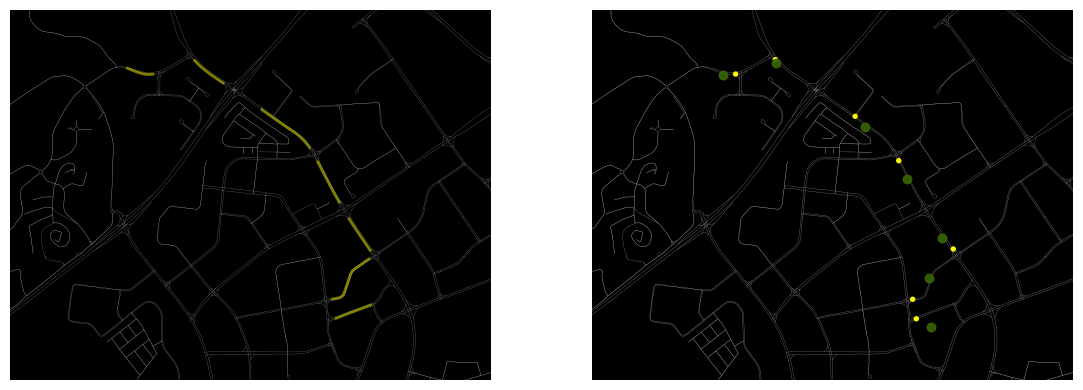

In [260]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
for ax in axes.flatten():
    ax.set_facecolor("black")
publicTransit.plot_bus_edges(G_car, gtfs, busLeg_dfs[busLeg_number], ax=axes[0], xlim_factor = 0.6,ylim_factor = 0.2)
publicTransit.plot_bus_nodes(G_car, gtfs, busLeg_dfs[busLeg_number],ax=axes[1],xlim_factor = 0.6,ylim_factor = 0.2)
plt.tight_layout()
plt.show()

# edges = get_bus_edges(G_car,busLeg_dfs[0],GTFS_shapes,plot=True)

### Get shortest path bus routes

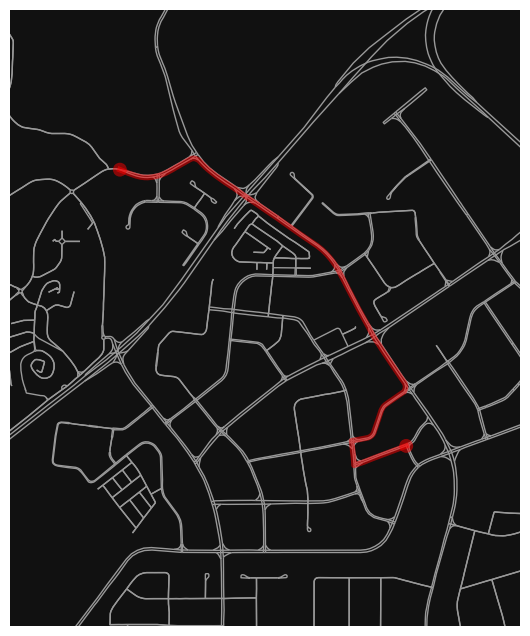

[246155560,
 2577843629,
 2577843618,
 246158694,
 2577843619,
 4745624418,
 246155892,
 2577843711,
 2577843712,
 2577843714,
 4745340939,
 2577843801,
 2577843843,
 244137878,
 244137918,
 2577843871,
 2618496604,
 889499177,
 2577843939,
 2618497983,
 6151629170,
 5159426232,
 4738356421,
 1301909257,
 4738356423,
 567938823,
 1304329326,
 1304329329,
 4604229203,
 1989607716,
 1989535699,
 4604229209,
 246168216]

In [265]:
BSR = publicTransit.BusStopRoutes(G=G_car,gtfs=gtfs)
BSR.busRoute_shortestPath(plot=True)

# Import error data

In [60]:
import json

def correctJSON(json_fp,save_fp="test.json"):
    """ this function corrects the serialisation of str into JSON as there are missing closure forms
    Args:
        json_fp (str): filepath of json file
    """
    with open(json_fp) as f:
        json_str = f.read()
    if json_str[-1] == ' ':
        json_str = json_str + 'null' + '}]' + '}'
        json_data = json.loads(json_str) # parse a JSON string and convert it into a Python object
        utils.json_data(json_data, save_fp)
        # json.loads(r'{}'.format(json_str))
        # delimiter: line 1 column 1784 (char 1783)
        return json_data
    else:
        print(f'Still unable to parse into JSON: {json_fp}')
        return json_str

correctJSON(r"D:\PAKHUIYING\publicTransit_busRouting\76079to4607055587_ERROR.json")

{'busStart': [1.34794388891649, 103.94563500000056, '76079'],
 'workEnd': [1.4480919633081966, 103.81028707234208, 4607055587],
 'duration': 6117,
 'startTime': 1738713656000,
 'endTime': 1738719773000,
 'transitTime': 5348,
 'waitingTime': 432,
 'transfers': 2,
 'busLegs': [{'leg_number': 0,
   'duration': 671,
   'distance': 3089.7,
   'startTime': 1738713656000,
   'endTime': 1738714327000,
   'tripId': '34B-1-1001',
   'tripDirection': 0,
   'mode': 'BUS',
   'routeId': '34B',
   'legGeometry': {'points': 'khfG{zlyR\\fAVv@t@zAHLx@xAbAzAfApA\\^e@^q@h@iAd@o@VcAReBX????_BViFv@K@gCRwCBc@@_@?[?i@?mDCA?c@???A?gCCu@?_CHe@Lc@Rc@R]Z[`@Q\\M^EVEd@?h@?jC??A~@?@?bD?`@?d@@vC?zB@XAP?X???bF?ZAVCn@Kp@o@bB????A@qAlDO^_@|@aAzB????w@fBeA`Ca@bAkAe@w@WwAUEA??kA[C?qBMcACiACyC?',
    'length': 86},
   'busLeg': [{'name': 'BLK 101',
     'stopId': 'FERRY:76079',
     'stopCode': '76079',
     'lon': 103.945635,
     'lat': 1.3479439,
     'departure': 1738713656000,
     'stopIndex': 32,
     'stopSequence

### Read files that triggered the try and except error

In [ ]:
error1 = utils.load_txt(r"data\busRoutingError2_10Feb.txt")
gtfs_error_ix = [int(i.split(',')[0].split(':')[0]) for i in error1]
workplace_error_ix  = [int(i.split(',')[1].split(':')[0]) for i in error1]
print(workplace_error_ix)
print(gtfs_error_ix)

save_dir = r"D:\PAKHUIYING\publicTransit_busRouting"
noData_file = os.path.join(r'data','busRoutingError5.txt')

for workplace_ix, gtfs_ix in zip(workplace_error_ix,gtfs_error_ix):
    gtfs_rows = GTFS_stops.loc[gtfs_ix,:]
    workplace_rows = workplace_cluster.loc[workplace_ix,:]

    # origin coords and origin key
    busStop_coords = (gtfs_rows['stop_lat'],gtfs_rows['stop_lon'])
    busStop_key = gtfs_rows['stop_id']
    # destination coords and destination key
    workplace_coords = (workplace_rows['latitude'], workplace_rows['longitude'])
    workplace_key = int(workplace_rows['node_ID'])
    # save_fp
    save_fp = os.path.join(save_dir,f'{busStop_key}to{workplace_key}.json')
    # export data
    try:
        itinerary = public_transit_routing(busStop_coords, busStop_key, 
                                        workplace_coords, workplace_key,
                        G_bus, GTFS_shapes, headers,
                            plot = False,
                            save_fp = save_fp)
    except:
        # export data that has an error
        print(f'{gtfs_ix}:{busStop_key},{workplace_ix}:{workplace_key}')
        if not os.path.exists(noData_file):
            with open(noData_file, "w") as myfile:
                myfile.write(f'{gtfs_ix}:{busStop_key},{workplace_ix}:{workplace_key}\n')

        else:
            with open(noData_file, "a") as myfile:
                myfile.write(f'{gtfs_ix}:{busStop_key},{workplace_ix}:{workplace_key}\n')
    

### Correct json file by refiltering GTFS data

In [ ]:
import json
def correctJSON(json_fp):
    """ this function corrects the serialisation of str into JSON as there are missing closure forms
    Args:
        json_fp (str): filepath of json file
    """
    with open(json_fp) as f:
        json_str = f.read()
    if json_str[-1] == ' ':
        json_str = json_str + 'null' + '}]' + '}'
        json_data = json.loads(json_str) # parse a JSON string and convert it into a Python object
        # utils.json_data(json_data, save_fp)
        # json.loads(r'{}'.format(json_str))
        # delimiter: line 1 column 1784 (char 1783)
        return json_data
    else:
        raise Exception(f'Still unable to parse into JSON: {json_fp}')

def correctError_publicTransitRouting(fp_error,G_bus,GTFS_shapes,headers,plot = True,):
    """ attempts to reconstruct the bus route path 
    Args:
        fp (str): filepath with error e.g. filepath that ends with fp
        G_bus (MultiDiGraph): graph of drive bus network
        GTFS_shapes (pd.DataFrame): dataframe of the GTFS's shapes file
        headers (dict): Authorization headers
        plot (bool): if True, plot shortest bus route
    Returns:
        dict: corrected itinerary
        str: filepath to store the updated itinerary if there are any updates
        str: error message for logging
    """
    
    # load fp that has at least 1 error in constructing the routes
    try:
        itinerary = utils.load_json(fp_error)
    except:
        # handle json parsing error
        itinerary = correctJSON(fp_error)

    # initialise error msg:
    error_msg = ''
    save_fp = fp_error

    # get fp for corrected data
    save_dir = os.path.dirname(fp_error)
    corrected_fp = os.path.splitext(os.path.basename(fp_error))[0]
    corrected_fp = corrected_fp.split('_')[0]
    corrected_fp = os.path.join(save_dir,f'{corrected_fp}.json')
    
    def checkGTFS(gtfs_df):
        """ check if df is of length 0"""
        if len(gtfs_df.index) == 0:
            raise Exception("GTFS df is of zero length!")
        else:
            return gtfs_df
    

    itinerary_copy = itinerary.copy()
    for busLeg_number, busLeg in enumerate(itinerary['busLegs']):
        tripDirection = busLeg['tripDirection']
        routeId = busLeg['routeId']
        stopSequence = pd.DataFrame(busLeg['busLeg'])
        stopSequence = stopSequence['stopSequence'].to_list()
        if len(busLeg['gtfs']) == 0:
            try:
                gtfs = checkGTFS(GTFS_shapes[(GTFS_shapes['shape_id'].str.contains(f'^{routeId}:WD:{tripDirection}.*')) & (GTFS_shapes['shape_pt_sequence'].isin(stopSequence))])
            except:
                try:
                    gtfs = checkGTFS(GTFS_shapes[(GTFS_shapes['shape_id'].str.contains(f'^{routeId}:SAT:{tripDirection}.*')) & (GTFS_shapes['shape_pt_sequence'].isin(stopSequence))])
                except:
                    try:
                        gtfs = checkGTFS(GTFS_shapes[(GTFS_shapes['shape_id'].str.contains(f'^{routeId}:SUN:{tripDirection}.*')) & (GTFS_shapes['shape_pt_sequence'].isin(stopSequence))])
                    except:
                        try:
                            # try getting a different bus leg journey at different times,
                            # because there may be Go-Ahead City Direct BUs Service during peak hours
                            busStop_coords = (itinerary['busStart'][0],itinerary['busStart'][1])
                            busStop_key = itinerary['busStart'][2]
                            workplace_coords = (itinerary['workEnd'][0],itinerary['workEnd'][1])
                            workplace_key = itinerary['workEnd'][2]
                            itinerary_retry = publicTransit.public_transit_routing(busStop_coords, busStop_key, 
                                                workplace_coords, workplace_key,
                                                G_bus, GTFS_shapes, headers,
                                                    plot = False,
                                                    date = '02-05-2025',
                                                    time = '12%3A00%3A00' ,
                                                    save_fp = corrected_fp)
                            
                            # if len(gtfs) == 0:
                            #     gtfs = None
                            #     error_msg = error_msg + f'Relevant GTFS data cannot be obtained from the routeId and trip direction.Check if GTFS has the bus service.: {routeId} '
                            # else:
                            return itinerary_retry, corrected_fp, error_msg
                        except:
                            gtfs = None
                            error_msg = error_msg + f'Retrying with fetching itinerary threw an exception error. '
            
            if gtfs is not None:
                gtfs = gtfs.sort_values('shape_pt_sequence')
                gtfs_dict = gtfs.to_dict('records')
                # overwrite record
                itinerary_copy['busLegs'][busLeg_number]['gtfs'] = gtfs_dict
                
                # get shortest bus route based on gtfs_shape sequence
                try:
                    BSR = publicTransit.BusStopRoutes(G=G_bus,gtfs=gtfs)
                    route_nodesID = BSR.busRoute_shortestPath(plot=plot)
                except Exception as e:
                    # if there is an error, change the save_fp name so that it's easy to identify the error                        
                    route_nodesID = None # save the error msg as nodesID
                    error_msg = error_msg + 'Bus stop routes cannot be reconstructed. '
                # overwrite record
                itinerary_copy['busLegs'][busLeg_number]['routesNodesID'] = route_nodesID
                
                if route_nodesID is not None:
                    save_fp = corrected_fp
    
    return itinerary_copy, save_fp, error_msg


itinerary, save_fp, error_msg = correctError_publicTransitRouting(error_fp[0],G_bus,GTFS_shapes, plot=False)
print(save_fp, error_msg)
itinerary

### log files that continue to have error even after refiltering GTFS data and reconstructing bus routes

In [61]:
busroutes_dir = r"D:\PAKHUIYING\publicTransit_busRouting"
error_fp = [os.path.join(busroutes_dir,fp) for fp in os.listdir(busroutes_dir) if fp.endswith('_ERROR.json')]
print(f'Number of error files: {len(error_fp)}')

Number of error files: 1499


Correct those error files where errors are due to missing weekday (WD) bus routes, retrying with bus routes found on SAT/SUN.

In [ ]:
# noData_file = os.path.join(r'data','error_reprocess_log1.txt')
# for i in range(len(error_fp[587:])):
#     itinerary, save_fp, error_msg = correctError_publicTransitRouting(error_fp[i],G_bus,GTFS_shapes, plot=False)
#     try:
#         utils.json_data(itinerary, save_fp)
#     except:
#         print('Object is not serializable as JSON')

#     if not os.path.exists(noData_file):
#         with open(noData_file, "w") as myfile:
#             myfile.write(f'{error_fp[i]},{save_fp},{error_msg}\n')

#     else:
#         with open(noData_file, "a") as myfile:
#             myfile.write(f'{error_fp[i]},{save_fp},{error_msg}\n')

Correct those error files where missing bus services are due to city-direct buses

In [ ]:
# error_fp = utils.load_txt(os.path.join(r'data','error_reprocess_log1.txt'))
# error_fp = [i.split(',')[1] for i in error_fp if (i.split(',')[1].endswith('ERROR.json')) and ("Check if GTFS has the bus service" in i.split(',')[2])]
# print(len(error_fp))
# noData_file = os.path.join(r'data','error_reprocess_log2.txt')
# for i in range(len(error_fp)):
#     itinerary, save_fp, error_msg = correctError_publicTransitRouting(error_fp[i],G_bus,GTFS_shapes, headers, plot=False)
#     try:
#         utils.json_data(itinerary, save_fp)
#     except:
#         print('Object is not serializable as JSON')

#     if not os.path.exists(noData_file):
#         with open(noData_file, "w") as myfile:
#             myfile.write(f'{error_fp[i]},{save_fp},{error_msg}\n')

#     else:
#         with open(noData_file, "a") as myfile:
#             myfile.write(f'{error_fp[i]},{save_fp},{error_msg}\n')

Identify missing bus services from GTFS

In [ ]:
# error_fp = utils.load_txt(os.path.join(r'data','error_reprocess_log2.txt'))
# # error_fp = [i.split(',')[1] for i in error_fp if (i.split(',')[1].endswith('ERROR.json')) and ("Check if GTFS has the bus service" in i.split(',')[2])]
# error_fp = [i.split(',')[1] for i in error_fp if (i.split(',')[1].endswith('ERROR.json'))]
# print(len(error_fp))

# noData_file = os.path.join(r'data','error_reprocess_log3.txt')
# for i in range(len(error_fp)):
#     try:
#         itinerary = utils.load_json(error_fp[i])
#         error_msg = ''
#         for busLeg in itinerary['busLegs']:
#             tripDirection = busLeg['tripDirection']
#             routeId = busLeg['routeId']
#             stopSequence = pd.DataFrame(busLeg['busLeg'])
#             stopSequence = stopSequence['stopSequence'].to_list()
#             stopSequence = ','.join(str(s) for s in stopSequence)
#             if len(busLeg['gtfs']) == 0:
#                 error_msg = error_msg + f'routeId:{routeId},tripDirection:{tripDirection},stopSequence:{stopSequence};'
#     except:
#         print('Object is not serializable as JSON')

#     if not os.path.exists(noData_file):
#         with open(noData_file, "w") as myfile:
#             myfile.write(f'{error_fp[i]},{error_msg}\n')

#     else:
#         with open(noData_file, "a") as myfile:
#             myfile.write(f'{error_fp[i]},{error_msg}\n')

Remove files that already has their errors corrected

In [ ]:
# error_fp = utils.load_txt(os.path.join(r'data','error_reprocess_log3.txt'))
# error_fp = [i.split(',')[1] for i in error_fp if ('ERROR' not in i.split(',')[1])]
# print(len(error_fp))

# def remove_error_files(fp):
#     fp_split = os.path.splitext(fp)[0]
#     fp_error = fp_split+'_ERROR.json'
#     if os.path.exists(fp) and os.path.exists(fp_error):
#         # print(fp_error)
#         os.remove(fp_error)
#     return fp_error

# error_fp
# for fp in error_fp:
#     remove_error_files(fp)

2 sources of error when filtering GTFS datasets from `routeID` and `tripDirections`:

1. Identify bus services that yield empty GTFS dataset. This could be because GTFS dataset do not have two trip directions (forward and reverse) for that bus service

2. If the GTFS dataset is not empty after filtering, it could be because bus routes number are not updated, and they are shortened, so the relevant bus sequence could not be identified in the GTFS dataset

In [ ]:
# missingBuses = utils.load_txt(r"data\MissingBusServiceFromGTFS.txt")
# error_fp = utils.load_txt(r"data\error_reprocess_log2.txt")
# # error_fp = [i.split(',')[1] for i in error_fp if (i.split(',')[1].endswith('ERROR.json')) and ("Check if GTFS has the bus service" in i.split(',')[2])]
# missingBuses_list = []
# nonempty_GTFS = []
# error_fp = [i.split(',')[1] for i in error_fp if (i.split(',')[1].endswith('ERROR.json'))]
# for mB, fp in zip(missingBuses,error_fp):
#     error_msg = mB.replace(f'{fp},','')
#     for msg in error_msg.split(';'):
#         if msg != '':
#             routeId = msg.split(',')[0].replace('routeId:','')
#             tripDirection = msg.split(',')[1].replace('tripDirection:','')
#             busSequence = msg.split('stopSequence:')[1]
#             bus_regex = f'^{routeId}:WD:{tripDirection}.*'
            
#             gtfs_filter = GTFS_shapes[(GTFS_shapes['shape_id'].str.contains(bus_regex))].sort_values('shape_pt_sequence')
#             if len(gtfs_filter.index) > 0: # if GTFS is not empty
#                 gtfs_busSeq = gtfs_filter['shape_pt_sequence'].to_list()
#                 busLeg_busSeq = [int(i) for i in busSequence.split(',')]
#                 nonempty_GTFS.append((bus_regex,busLeg_busSeq,gtfs_busSeq))
#             else: # if GTFS is empty
#                 missingBuses_list.append(bus_regex)

# missingBuses_list = list(set(missingBuses_list))
# missingBuses_list

# # export error data
# noData_file = os.path.join(r'data','GTFS_missingBusServices.txt')
# if not os.path.exists(noData_file):
#     with open(noData_file, "w") as myfile:
#         myfile.write('\n'.join(missingBuses_list))

# noData_file = os.path.join(r'data','GTFS_shortenedBusServices.pkl')
# utils.pickle_data(nonempty_GTFS,noData_file)

Update GTFS dataframe
1. remove old GTFS shape rows from GTFS
2. append missing GTFS rows to df
3. Export updated GTFS as csv

In [ ]:
# def update_GTFS(GTFS_shapes):
#     GTFS_shapes_copy = GTFS_shapes.copy()
#     drop_shape_id = []
#     GTFS_missingBusServices_dir = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\missing_gtfs_shape"
#     df_append = []
#     for fp in os.listdir(GTFS_missingBusServices_dir):
#         fp = os.path.join(GTFS_missingBusServices_dir,fp)
#         df = pd.read_csv(fp)
#         shape_id = df['shape_id'][0]
#         drop_shape_id.append(shape_id)
#         df_append.append(df)
#     # drop GTFS old routes so they dont overlap with the new GTFS appended
#     gtfs_dropped = GTFS_shapes_copy[~GTFS_shapes_copy['shape_id'].isin(drop_shape_id)]
#     # concat new GTFS routes
#     gtfs_new = pd.concat(df_append,axis=0)
#     gtfs_new = gtfs_new[['shape_id','shape_pt_lat','shape_pt_lon','shape_pt_sequence']]
#     return pd.concat([GTFS_shapes_copy,gtfs_new],axis=0)
# GTFS_shapes_updated = update_GTFS(GTFS_shapes)
# GTFS_shapes_updated.to_csv(os.path.join(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA",
#                                        f"GTFS_shapes_3Mar2025.csv"),index=False)
# GTFS_shapes_updated

Retry error files with updated GTFS data

In [ ]:
# error_fp = utils.load_txt(os.path.join(r'data','error_reprocess_log2.txt'))
# # error_fp = [i.split(',')[1] for i in error_fp if (i.split(',')[1].endswith('ERROR.json')) and ("Check if GTFS has the bus service" in i.split(',')[2])]
# error_fp = [i.split(',')[1] for i in error_fp if (i.split(',')[1].endswith('ERROR.json'))]
# print(len(error_fp))

# noData_file = os.path.join(r'data','error_reprocess_log3.txt')
# for i in range(len(error_fp)):
#     itinerary, save_fp, error_msg = correctError_publicTransitRouting(error_fp[i],G_bus,GTFS_shapes_new, headers, plot=False)
#     try:
#         utils.json_data(itinerary, save_fp)
#     except:
#         print('Object is not serializable as JSON')

#     if not os.path.exists(noData_file):
#         with open(noData_file, "w") as myfile:
#             myfile.write(f'{error_fp[i]},{save_fp},{error_msg}\n')

#     else:
#         with open(noData_file, "a") as myfile:
#             myfile.write(f'{error_fp[i]},{save_fp},{error_msg}\n')

In [63]:
# # # # save walking network
save_dir = os.path.join(os.getcwd(),"data")

filename = "SG_bus_network.graphml"

G_bus = ox.load_graphml(os.path.join(save_dir,filename))

         shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0  374:WD:0_shape      1.398990    103.888778                 15
1  374:WD:0_shape      1.398044    103.893440                 16
2  374:WD:0_shape      1.394956    103.894368                 17
                 name       stopId stopCode         lon       lat  \
0            BLK 338A  FERRY:67691    67691  103.888775  1.398993   
1  Opp Treasure Crest  FERRY:67641    67641  103.893440  1.398045   
2             BLK 261  FERRY:67411    67411  103.894297  1.394766   

         arrival      departure  stopIndex  stopSequence vertexType  
0  1738714823000  1738714823000         14            15    TRANSIT  
1  1738714909000  1738714939000         15            16    TRANSIT  
2  1738715011000  1738715207000         16            17    TRANSIT  


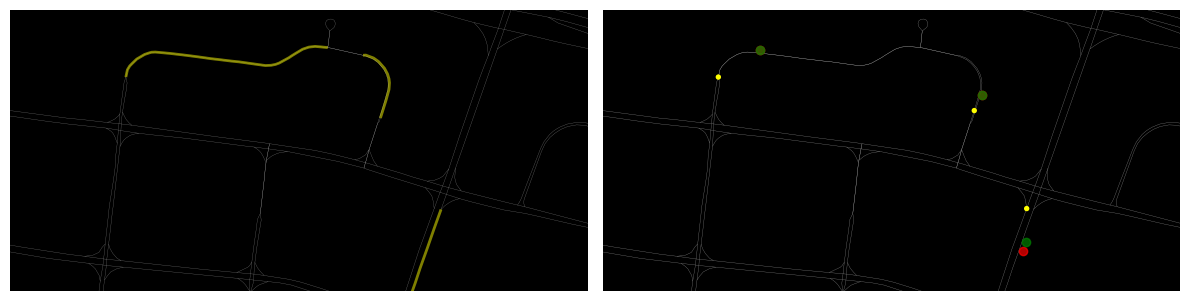

In [64]:
itinerary = utils.load_json(r"D:\PAKHUIYING\publicTransit_busRouting\67691to6247137952_ERROR.json")
gtfs = pd.DataFrame(itinerary['busLegs'][0]['gtfs'])
print(gtfs)
busLeg_df = pd.DataFrame(itinerary['busLegs'][0]['busLeg'])
print(busLeg_df)

fig, axes = plt.subplots(1,2, figsize=(12,4))
for ax in axes.flatten():
    ax.set_facecolor("black")
publicTransit.plot_bus_edges(G_bus, gtfs, busLeg_df, ax=axes[0], xlim_factor = 0.6,ylim_factor = 0.2)
publicTransit.plot_bus_nodes(G_bus, gtfs, busLeg_df,ax=axes[1],xlim_factor = 0.6,ylim_factor = 0.2)
plt.tight_layout()
plt.show()


Shortest path route does not return a list: <class 'NoneType'>
7702294981 to 4430972597
[5015083887, 3854144926, 7702294981, 4430972597]
Shortest path route does not return a list: <class 'NoneType'>


[5015083887,
 3854144934,
 3854144934,
 5015083887,
 3854144926,
 3854144926,
 7702294981,
 4430972597]

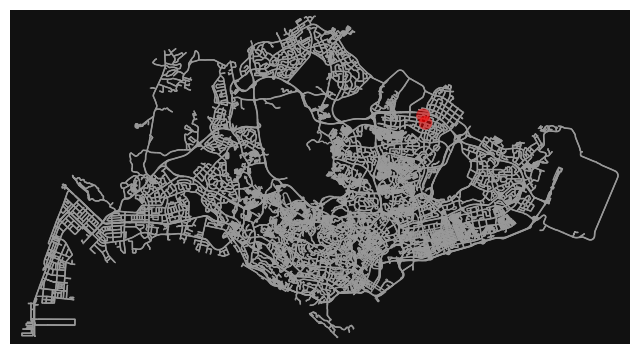

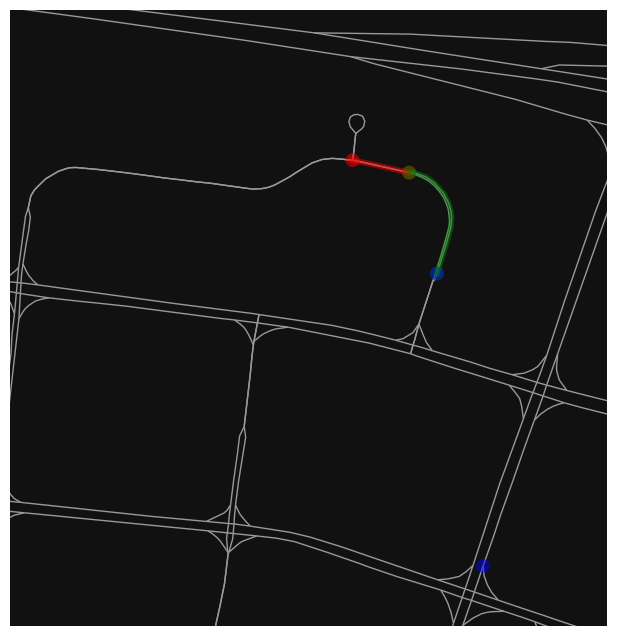

In [71]:
BSR = publicTransit.BusStopRoutes(G=G_bus,gtfs=gtfs)
route_nodesID = BSR.busRoute_shortestPath(plot=True)
print(route_nodesID)
all_nodesID = BSR.get_bus_edges_nodes()
all_nodesID

No shortest path found


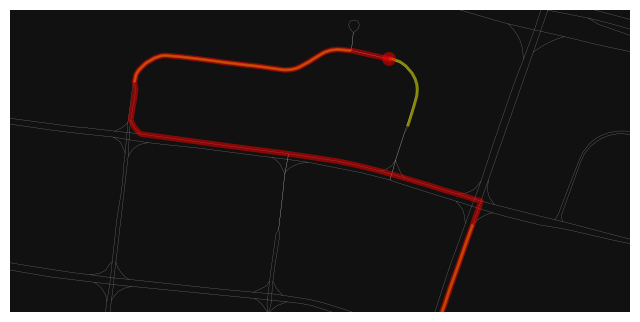

In [73]:
fig, ax = publicTransit.plot_bus_edges(G_bus, gtfs, busLeg_df, xlim_factor = 0.6,ylim_factor = 0.2)
# 3854144926,
#  7702294981,
#  4430972597
x = ox.shortest_path(G_bus, 3854144926,4430972597, weight="travel_time")
ox.plot_graph_route(G_bus, x, node_size=0,
                                    route_color="r",
                                    ax=ax,show=False,close=False)
x = ox.shortest_path(G_bus, 7702294981,4430972597, weight="travel_time")
if x is not None:
    ox.plot_graph_route(G_bus, x, node_size=0,
                                        route_color="b",
                                        ax=ax,show=False,close=False)
else:
    print('No shortest path found')

In [53]:
from datetime import datetime
datetime.fromtimestamp(response['plan']['itineraries'][0]['startTime']/1000).strftime('%Y-%m-%d %H:%M:%S')
# stops_df['arrival'] = pd.to_datetime(stops_df['arrival'],unit='ms')
# stops_df['departure'] = pd.to_datetime(stops_df['departure'],unit='ms')

'2023-08-13 07:35:00'

In [67]:
print(response['plan']['itineraries'][0]['legs'][0]['startTime'])
print(response['plan']['itineraries'][0]['legs'][0]['endTime'])
print(response['plan']['itineraries'][0]['legs'][0]['mode'])
print(response['plan']['itineraries'][0]['legs'][0]['from'])
print(response['plan']['itineraries'][0]['legs'][0]['to'])
print(response['plan']['itineraries'][0]['legs'][0]['distance']) # distance in metres
print(response['plan']['itineraries'][0]['legs'][0]['pathway'])
print(response['plan']['itineraries'][0]['legs'][0]['duration']) # duration in seconds

1691883300000
1691885159000
WALK
{'name': 'Origin', 'lon': 103.84415, 'lat': 1.320981, 'departure': 1691883300000, 'vertexType': 'NORMAL'}
{'name': 'Destination', 'lon': 103.8559, 'lat': 1.326762, 'arrival': 1691885159000, 'vertexType': 'NORMAL'}
1971.42
False
1859


In [60]:
datetime.fromtimestamp(response['plan']['itineraries'][0]['legs'][0]['endTime']/1000) - datetime.fromtimestamp(response['plan']['itineraries'][0]['startTime']/1000)


datetime.timedelta(seconds=1859)